# Exploração do complexo alimentar indiano
Nesse notebook nos propomos a explorar graficamente, utilizando grafos, dados envolvendo a culinária indiana, sua geografia, ingredientes, sabores e tipos de refeição.
Os grafos plotados e mostrados durante o código não são finais; todos os grafos finais, em HTML, serão salvos na pasta "Grafos", na raiz do projeto. O dumping do BD se encontra na pasta "Dumping". A pasta "Creating_DB" possui o código utilizado para transformar nosso dataset original, um CSV em SQLite.

## Import dos pacotes necessários

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np

from pyvis.network import Network
from itertools import combinations
import matplotlib.pyplot as plt
import sqlite3

## Conexão ao BD e extração do dataframe a ser trabalhado

In [ ]:
conn = sqlite3.connect("indian_food.sqlite")
query = """
SELECT fd.food_name AS 'name', cr.course_name AS 'course', fp.flavor_name AS 'flavor_profile', dt.diet_name AS 'diet', fd.ingredients AS 'ingredients', fd.prep_time AS 'prep_time', fd.cook_time AS 'cook_time', st.state_name AS 'state', rg.region_name AS 'region'
FROM Food AS 'fd', Course AS 'cr', Flavor_profile AS 'fp', State AS 'st', Diet AS 'dt', Region AS 'rg'
WHERE fd.diet_id == dt.diet_id AND fd.flavor_id == fp.flavor_id AND fd.course_id == cr.course_id AND fd.region_id == rg.region_id AND fd.state_id == st.state_id;
"""
backup_df = pd.read_sql(query, conn)

flt = backup_df['course'] != 'starter'
backup_df = backup_df[ flt ]

df = backup_df
df.head(3)

,name,course,flavor_profile,diet,ingredients,prep_time,cook_time,state,region
0,Balu shahi,dessert,sweet,vegetarian,"Maida flour, yogurt, oil, sugar",45,25,West Bengal,East
1,Boondi,dessert,sweet,vegetarian,"Gram flour, ghee, sugar",80,30,Rajasthan,West
2,Gajar ka halwa,dessert,sweet,vegetarian,"Carrots, milk, sugar, ghee, cashews, raisins",15,60,Punjab,North


# Grafo 1

*nx.from_pandas_edges* conecta os nós e já os adiciona, caso não existam 
*nx.compose* junta dois grafos, mantendo apenas uma ocorrência de nós repetidos e mantendo as arestas de todas elas

### Legenda

* Azul: Tipo da refeição
* Vermelho: Nome do prato
* Amarelo: Região

In [ ]:
G = nx.Graph()

df = backup_df.sample(70)

for idx in df.index:
    node = df.loc[idx, 'name']
    label = node.title()
    prep_time = int(df.loc[idx, 'prep_time'])
    cook_time = int(df.loc[idx, 'cook_time'])
    ingredients = [i.title() for i in df.loc[idx, 'ingredients'].split(', ')]
    diet = df.loc[idx, 'diet'].title()
    flavor_profile = df.loc[idx, 'flavor_profile'].title()
    course = df.loc[idx, 'course'].title()
    region = df.loc[idx, 'region'].title()
    state = df.loc[idx, 'state'].title()
    title_text = f"""Nome do prato: {node}<br>
    Ingredientes: {', '.join(ingredients)}<br>
    Cozinha: {cook_time} min<br>
    Preparação: {prep_time} min<br>
    Sabor: {flavor_profile}<br>
    Categoria: {course}<br>
    Estado: {state}<br>
    Região: {region}"""

    G.add_node(node, label=label, prep_time=prep_time, cook_time=cook_time, ingredients=ingredients, diet=diet, flavor_profile=flavor_profile, \
    course=course, region=region, state=state, color='#FF0000', size=10, title=title_text)

    G.add_node(df.loc[idx, 'state'], color='#F2AD00', size=15, label=df.loc[idx, 'state'].title())
    G.add_node(df.loc[idx, 'course'], color='#5BBCD6', size=30, label=df.loc[idx, 'course'].title())

    G.add_edge(df.loc[idx, 'name'], df.loc[idx, 'state'], color='#808080')
    G.add_edge(df.loc[idx, 'name'], df.loc[idx, 'course'], color='#808080')

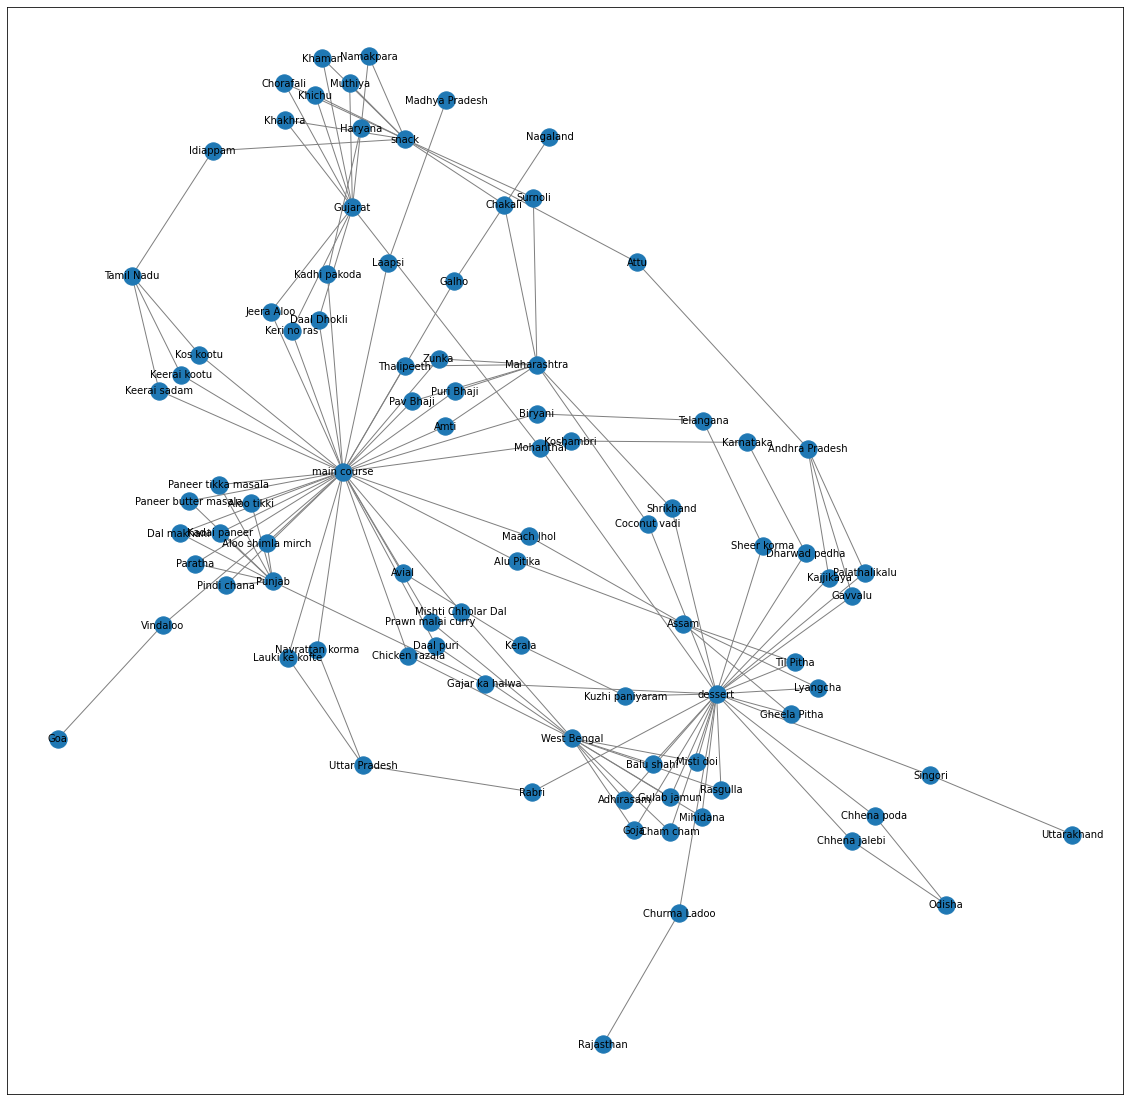

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
pos = nx.spring_layout(G, scale=1)

nx.draw_networkx(G, 
                 pos=pos, 
                 ax=ax,
                 node_shape='o',
                 alpha=1.0,
                 cmap=None,
                 vmin=None,
                 vmax=None,
                 linewidths=1.0,
                 width=1.0,
                 edge_color='gray',
                 edge_cmap=None,
                 edge_vmin=None,
                 edge_vmax=None,
                 style='solid',
                 font_size=None,
                 font_color=None,
                 font_weight=None,
                 font_family=None,
                 label=None,)

plt.show()

In [ ]:
nt = Network(height='800px', width='100%', heading='Grafo 1')
nt.from_nx(G)
nt.show('Grafos/'+'Grafo_1.html')

# Grafo 2

Conta quantas vezes cada ingrediente aparece e, em seguida, filtra os ingredientes mais comuns (mais de 5 aparições)
### Legenda

* Azul: Tipo da refeição
* Vermelho: Nome do prato
* Amarelo: Região
* Verde: Ingrediente

In [ ]:
df = backup_df.sample(40)

df['ingredients'] = df['ingredients'].to_list()
recipes = df['ingredients']

ingrd_list = []

for recipe in recipes:
    ingrd = [x for x in recipe.split(', ')]
    ingrd_list += ingrd
ingrd_list = pd.Series(ingrd_list)

#print(ingrd_list.value_counts().head(10))

In [ ]:
ingred = ingrd_list.value_counts()
selected_ingred = ingred[ ingred >= 5 ]
not_selected_ingred = ingred[ ingred < 5 ]

Cria colunas baseando-se nos ingredientes


In [ ]:
df_temp = df['ingredients'].str.get_dummies(', ').drop(not_selected_ingred.index, axis=1)
df_merged = df.merge(df_temp, left_index=True, right_index=True)

#Coloca as conexões de ingredientes e comidas numa coluna só para criar a lista de arestas
df_melted = df_merged.melt(id_vars=['name'], value_vars=selected_ingred.index, var_name='ingredient').query('value == 1').drop('value', axis=1)
df_melted

In [ ]:
#Criando o grafo:

G = nx.Graph()


for idx in df.index:

    node = df.loc[idx, 'name']
    label = node.title()
    prep_time = int(df.loc[idx, 'prep_time'])
    cook_time = int(df.loc[idx, 'cook_time'])
    ingredients = [i.title() for i in df.loc[idx, 'ingredients'].split(', ')]
    diet = df.loc[idx, 'diet'].title()
    flavor_profile = df.loc[idx, 'flavor_profile'].title()
    course = df.loc[idx, 'course'].title()
    region = df.loc[idx, 'region'].title()
    state = df.loc[idx, 'state'].title()
    title_text = f"""Nome do prato: {node}<br>
    Ingredientes: {', '.join(ingredients)}<br>
    Cozinha: {cook_time} min<br>
    Preparação: {prep_time} min<br>
    Sabor: {flavor_profile}<br>
    Categoria: {course}<br>
    Estado: {state}<br>
    Região: {region}"""

    G.add_node(node, label=label, color='#FF0000', node_type='dish', prep_time=prep_time, cook_time=cook_time, \
    ingredients=ingredients, diet=diet, flavor_profile=flavor_profile, size=10, course=course, region=region,  \
    state=state, title=title_text)
    G.add_node(course, color='#5BBCD6', node_type='course', size=30)
    G.add_node(state, color='#F2AD00', node_type='state', size=15)

    for igr in ingredients:
        G.add_node(igr, node_type='ingredient', size=7, color='#00A08A')
        G.add_edge(node, igr, color='#808080')

    G.add_edge(node, course, color='#808080')
    G.add_edge(node, state, color='#808080')

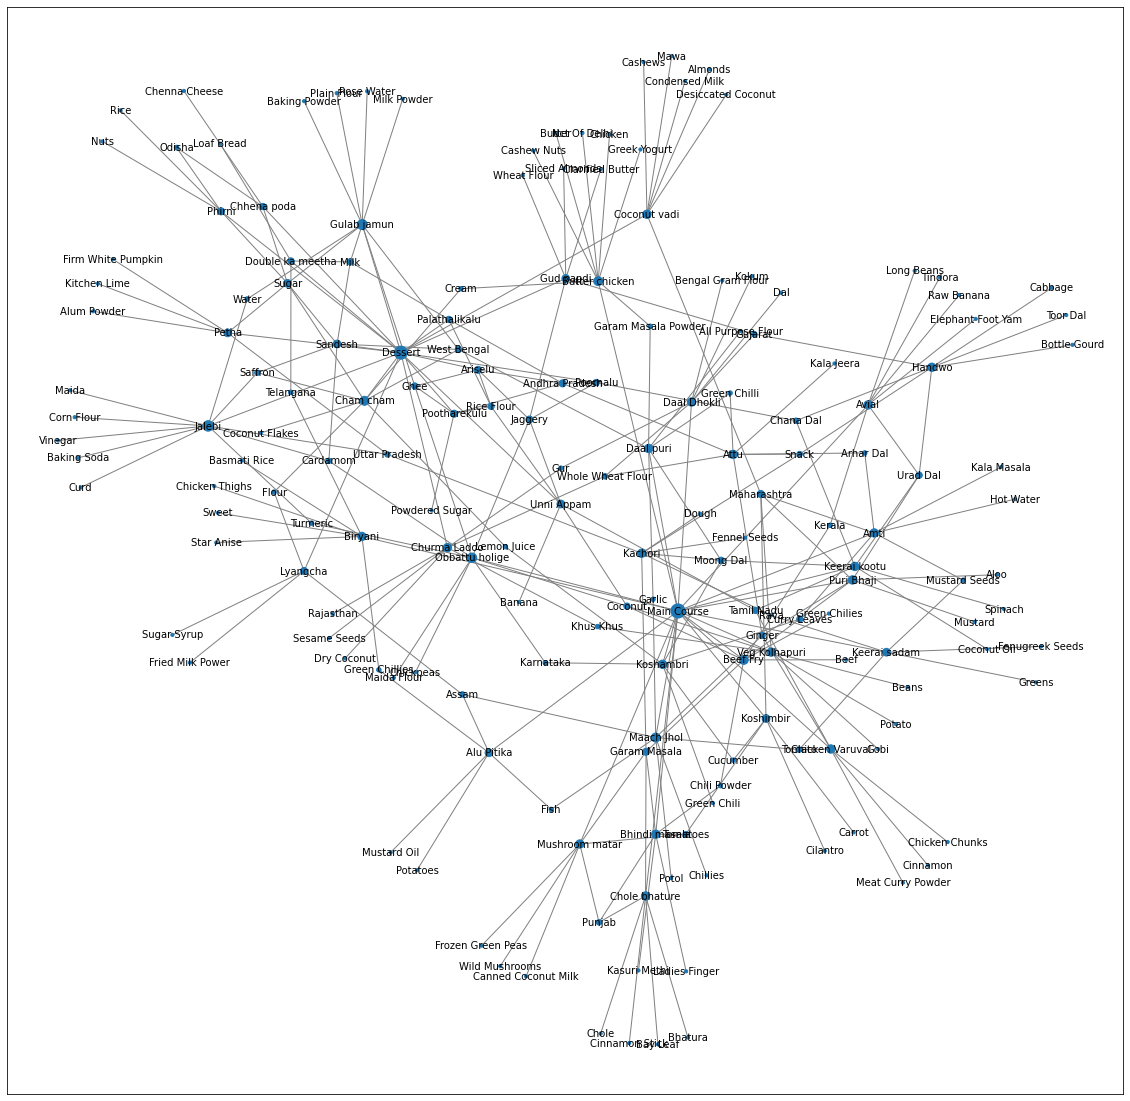

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
pos = nx.spring_layout(G, scale=1)

nx.draw_networkx(G,
                 pos=pos, 
                 ax=ax,
                 node_size=[G.degree[node] * 10 for node in G.nodes],
                 node_shape='o',
                 alpha=1.0,
                 cmap=None,
                 vmin=None,
                 vmax=None,
                 linewidths=1.0,
                 width=1.0,
                 edge_color='gray',
                 edge_cmap=None,
                 edge_vmin=None,
                 edge_vmax=None,
                 style='solid',
                 font_size=None,
                 font_color=None,
                 font_weight=None,
                 font_family=None,
                 label=None,)

plt.show()

In [ ]:
nt = Network(height='800px', width='100%', heading='Grafo 2')
nt.from_nx(G)
nt.show('Grafos/' + 'Grafo_2.html')

# Grafo 3

Tirando pratos e deixando ingredientes como nós principais

* 425 ingredientes únicos
* Vamos pegar uma parte menos do df
* Cor e tamanho relacionados à quantidade de vezes que o ingrediente é usado.

In [ ]:
# 425 ingredientes únicos
# Vamos pegar uma parte menos do df

df = backup_df

new_df = df.sample(50)

G = nx.Graph()

for idx in new_df.index:
    ingredients = [str(i) for i in new_df.loc[idx, 'ingredients'].split(', ')]
    course = new_df.loc[idx, 'course']

    for ingredient in ingredients:
        if ingredient in G.nodes:
            G.nodes[ingredient]['size'] += 3

            if course in G.nodes[ingredient]['course'].keys():
                G.nodes[ingredient]['course'][course] += 1
            else:
                G.nodes[ingredient]['course'][course] = 1

        else:
            G.add_node(ingredient, size=10, group='ingredient', course={course: 1})
    

    for edge in combinations(ingredients, 2):
        if edge in G.edges:
            G.edges[edge]['size'] += 2
        else:
            G.add_edge(*edge, size=5, color='#808080')

In [ ]:
def getMaxValue(G):
    maximum = max(nx.get_node_attributes(G, 'size').values())
    return maximum

def getColor(divider, node, color):
    value = node['size']
    rgb = [round(int(i) * value / divider) for i in color]
    RGB = [f'{i:02X}' for i in rgb]
    return '#' + ''.join(RGB)
    

In [ ]:
maximum = getMaxValue(G)
color = [255, 0, 0] # red
for node in G.nodes:
    G.nodes[node]['color'] = getColor(maximum, G.nodes[node], color)
    G.nodes[node]['label'] = node.title()

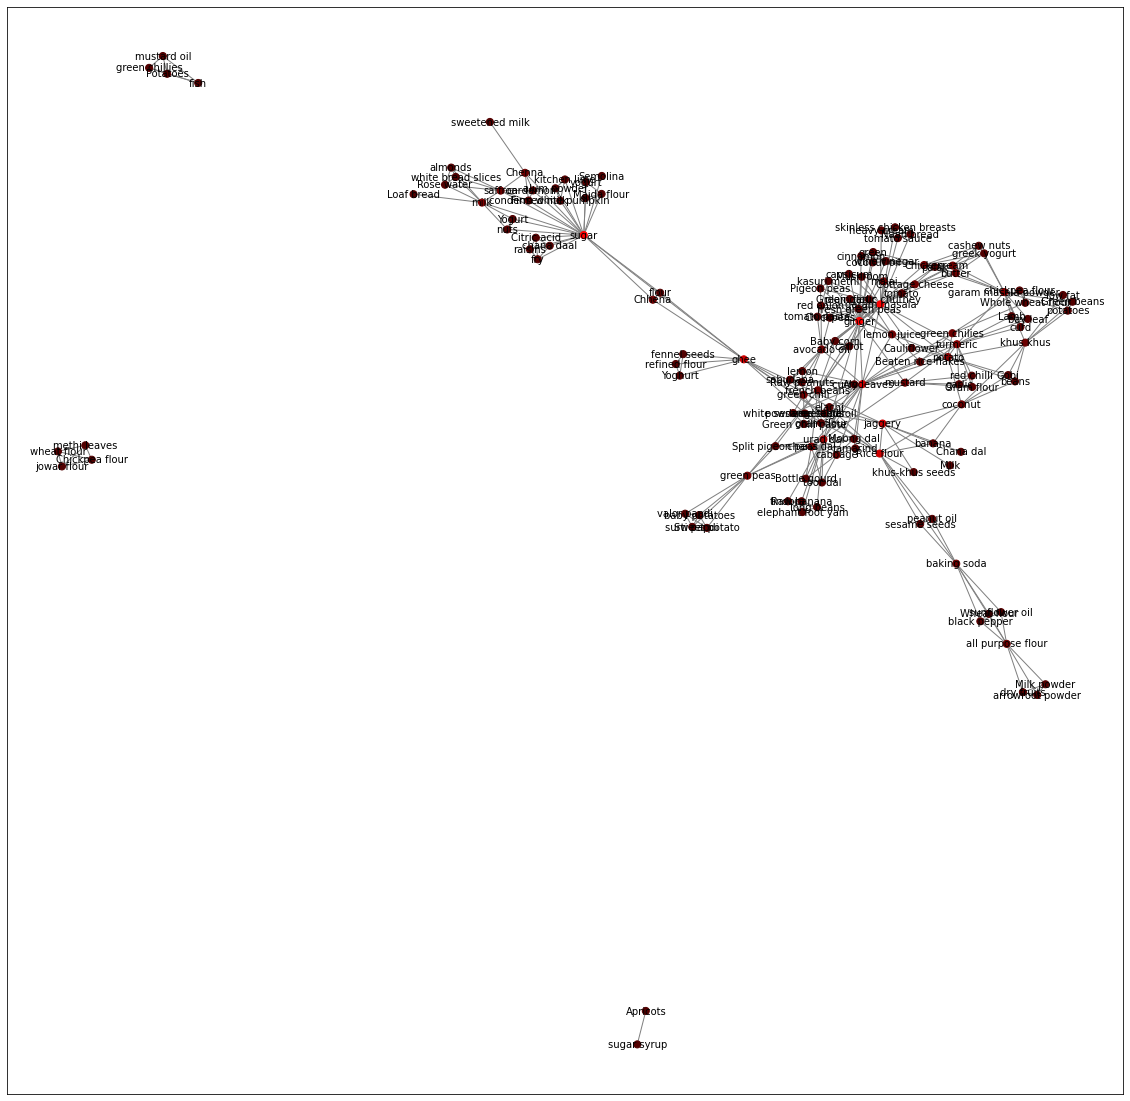

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
pos = nx.spring_layout(G, scale=1)

nx.draw_networkx(G,
                 pos=pos, 
                 ax=ax,
                 node_size=50,
                 node_color=[nx.get_node_attributes(G, 'color')[node] for node in G],
                 node_shape='o',
                 alpha=1.0,
                 cmap=None,
                 vmin=None,
                 vmax=None,
                 linewidths=1.0,
                 width=1.0,
                 edge_color='gray',
                 edge_cmap=None,
                 edge_vmin=None,
                 edge_vmax=None,
                 style='solid',
                 font_size=None,
                 font_color=None,
                 font_weight=None,
                 font_family=None,
                 label=None,)

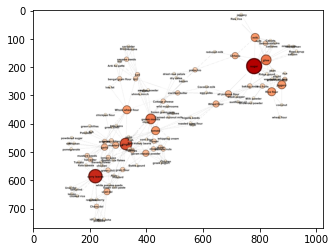

In [ ]:
img = plt.imread('from_gephi_1.png')
plt.imshow(img)
plt.show()

In [ ]:
nt = Network(height='800px', width='100%', heading='Grafo 3')
nt.from_nx(G)
nt.set_options='''
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -4900,
      "centralGravity": 0.65,
      "avoidOverlap": 1
    },
    "minVelocity": 0.75
  }
}
'''
nt.show('Grafos/' + 'Grafo_3.html')